# Title

<!-- For PDF export only -->
::: {pdf}
## Assignment
Import, tidy and analyze the NYPD Shooting Incident dataset obtained. Be sure your project is reproducible and contains some visualization and analysis. You may use the data to do any analysis that is of interest to you. You should include at least two visualizations and one model. Be sure to identify any bias possible in the data and in your analysis.
:::

In [1]:
library(tidyverse)
library(lubridate)
library(forecast)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
# import the source data and put it in a df
source_url <- paste0(
  "https://data.cityofnewyork.us/api/views/833y-fsy8/rows.csv?",
  "accessType=DOWNLOAD"
)

incident_df <- read.csv(source_url)

## Explore

In [3]:
# see what columns we have and what data types
glimpse(incident_df)

Rows: 28,562
Columns: 21
$ INCIDENT_KEY            <int> 244608249, 247542571, 84967535, 202853370, 270~
$ OCCUR_DATE              <chr> "05/05/2022", "07/04/2022", "05/27/2012", "09/~
$ OCCUR_TIME              <chr> "00:10:00", "22:20:00", "19:35:00", "21:00:00"~
$ BORO                    <chr> "MANHATTAN", "BRONX", "QUEENS", "BRONX", "BROO~
$ LOC_OF_OCCUR_DESC       <chr> "INSIDE", "OUTSIDE", "", "", "", "", "", "", "~
$ PRECINCT                <int> 14, 48, 103, 42, 83, 23, 113, 77, 48, 49, 73, ~
$ JURISDICTION_CODE       <int> 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ LOC_CLASSFCTN_DESC      <chr> "COMMERCIAL", "STREET", "", "", "", "", "", ""~
$ LOCATION_DESC           <chr> "VIDEO STORE", "(null)", "", "", "", "MULTI DW~
$ STATISTICAL_MURDER_FLAG <chr> "true", "true", "false", "false", "false", "fa~
$ PERP_AGE_GROUP          <chr> "25-44", "(null)", "", "25-44", "25-44", "", "~
$ PERP_SEX                <chr> "M", "(null)", "", "M", "M", "", "", "", "", "~
$ PERP_RACE    

I already see lots of nulls, empty strings, missing values, etc. Let's take a closer look at some of the categorical columns to see if there are a limited number of consistently entered values or if they were entered as free text, which might be too difficult to clean.

In [4]:
# break out all the unique values and counts
desc_counts <- lapply(incident_df[,
  c(
    "LOC_CLASSFCTN_DESC",
    "LOCATION_DESC",
    "PERP_RACE",
    "VIC_RACE",
    "LOC_OF_OCCUR_DESC",
    "VIC_SEX",
    "PERP_SEX"
  )
], table)

print(desc_counts)

$LOC_CLASSFCTN_DESC

                 (null)  COMMERCIAL    DWELLING     HOUSING       OTHER 
      25596           2         208         243         460          59 
PARKING LOT  PLAYGROUND      STREET     TRANSIT     VEHICLE 
         15          41        1886          23          29 

$LOCATION_DESC

                                             (null)                       ATM 
                    14977                      1711                         1 
                     BANK            BAR/NIGHT CLUB         BEAUTY/NAIL SALON 
                        3                       668                       119 
              CANDY STORE               CHAIN STORE                CHECK CASH 
                        7                         7                         1 
        CLOTHING BOUTIQUE           COMMERCIAL BLDG                DEPT STORE 
                       14                       304                         9 
           DOCTOR/DENTIST                DRUG STORE       DRY 

Everything seems to be consistently entered (no misspellings or variations.) But there is a weird mix of "unknown", "U", and "null". It will probably be best to recode empty values as "Unknown" for consistency. There is something weird in a few columns too.

In [5]:
unique(incident_df$PERP_RACE)
table(incident_df$PERP_RACE)


[1] "BLACK"                          "(null)"                        
[3] ""                               "UNKNOWN"                       
[5] "WHITE HISPANIC"                 "BLACK HISPANIC"                
[7] "ASIAN / PACIFIC ISLANDER"       "WHITE"                         
[9] "AMERICAN INDIAN/ALASKAN NATIVE"


                                                       (null) 
                          9310                           1141 
AMERICAN INDIAN/ALASKAN NATIVE       ASIAN / PACIFIC ISLANDER 
                             2                            169 
                         BLACK                 BLACK HISPANIC 
                         11903                           1392 
                       UNKNOWN                          WHITE 
                          1837                            298 
                WHITE HISPANIC 
                          2510 

Oh, that's annoying - there is an empty string ```''``` as one of the largest groups, I guess the best option will be to categorize that as ```"UNKNOWN"``` as well. While I'm at it I'm going to make the date time columns a little more usable by separating out the date and time and converting them to the right type.


---

## Cleanup

In [6]:
clean_incident_df <- incident_df %>%
  mutate(
    # Combine the date and time into a proper DateTime object
    Date = as.POSIXct(
      paste(OCCUR_DATE, OCCUR_TIME), 
      format = "%m/%d/%Y %H:%M:%S"
    )
  ) %>%
  rename(
    In_Out = LOC_OF_OCCUR_DESC, 
    Location_Category = LOC_CLASSFCTN_DESC, 
    Location_details = LOCATION_DESC
  ) %>%
  select(
    Date, BORO, Location_Category, Location_details, 
    In_Out, OCCUR_DATE, OCCUR_TIME, 
    -JURISDICTION_CODE, -X_COORD_CD, -Y_COORD_CD,
    -Latitude, -Longitude, -Lon_Lat, -PRECINCT,
    everything()
  ) %>%
  mutate(
    # Recode specific values in PERP_RACE and VIC_RACE
    PERP_RACE = recode(PERP_RACE, 
                       "ASIAN / PACIFIC ISLANDER" = "ASIAN_PAC_ISLAND",
                       "AMERICAN INDIAN/ALASKAN NATIVE" = "AM_INDIAN/ALASKAN"
    ),
    VIC_RACE = recode(VIC_RACE, 
                      "ASIAN / PACIFIC ISLANDER" = "ASIAN_PAC_ISLAND",
                      "AMERICAN INDIAN/ALASKAN NATIVE" = "AM_INDIAN/ALASKAN"
    ),
    # Recode empty or null values to "UNKNOWN" for PERP_RACE
    PERP_RACE = ifelse(PERP_RACE == "", "UNKNOWN", PERP_RACE),
    
    # Recode unknown, empty, or NA values to "U" for both victim and perpetrator sex
    PERP_SEX = ifelse(PERP_SEX %in% c("Unknown", "","(null)", NA), "U", PERP_SEX),
    VIC_SEX = ifelse(VIC_SEX %in% c("Unknown", "", NA), "U", VIC_SEX)
  )

# Check that the recoding worked as expected
unique(clean_incident_df$PERP_SEX)  # Should show only "M", "F", and "U"
unique(clean_incident_df$VIC_SEX)   # Should show only "M", "F", and "U"
# check that I have the columns and order that I wanted
glimpse(clean_incident_df)

# check that we fixed the empty string values
unique(clean_incident_df$PERP_RACE)

# printing a df is a little uglier in some ways but prevents text
# overlap when there are lots of columns or long column names
print(tail(clean_incident_df))

[1] "M" "U" "F"

[1] "M" "F" "U"

Rows: 28,562
Columns: 22
$ Date                    <dttm> 2022-05-05 00:10:00, 2022-07-04 22:20:00, 201~
$ BORO                    <chr> "MANHATTAN", "BRONX", "QUEENS", "BRONX", "BROO~
$ Location_Category       <chr> "COMMERCIAL", "STREET", "", "", "", "", "", ""~
$ Location_details        <chr> "VIDEO STORE", "(null)", "", "", "", "MULTI DW~
$ In_Out                  <chr> "INSIDE", "OUTSIDE", "", "", "", "", "", "", "~
$ OCCUR_DATE              <chr> "05/05/2022", "07/04/2022", "05/27/2012", "09/~
$ OCCUR_TIME              <chr> "00:10:00", "22:20:00", "19:35:00", "21:00:00"~
$ INCIDENT_KEY            <int> 244608249, 247542571, 84967535, 202853370, 270~
$ PRECINCT                <int> 14, 48, 103, 42, 83, 23, 113, 77, 48, 49, 73, ~
$ JURISDICTION_CODE       <int> 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ STATISTICAL_MURDER_FLAG <chr> "true", "true", "false", "false", "false", "fa~
$ PERP_AGE_GROUP          <chr> "25-44", "(null)", "", "25-44", "25-44", "", "~
$ PERP_SEX     

[1] "BLACK"             "(null)"            "UNKNOWN"          
[4] "WHITE HISPANIC"    "BLACK HISPANIC"    "ASIAN_PAC_ISLAND" 
[7] "WHITE"             "AM_INDIAN/ALASKAN"

                     Date      BORO Location_Category          Location_details
28557 2023-07-02 21:40:00     BRONX            STREET                    (null)
28558 2023-03-19 23:48:00     BRONX        COMMERCIAL            GROCERY/BODEGA
28559 2023-08-16 02:46:00     BRONX            STREET                    (null)
28560 2023-06-27 12:27:00     BRONX          DWELLING   MULTI DWELL - APT BUILD
28561 2023-07-08 11:27:00    QUEENS            STREET         BEAUTY/NAIL SALON
28562 2023-07-24 23:38:00 MANHATTAN           HOUSING MULTI DWELL - PUBLIC HOUS
       In_Out OCCUR_DATE OCCUR_TIME INCIDENT_KEY PRECINCT JURISDICTION_CODE
28557 OUTSIDE 07/02/2023   21:40:00    270719378       46                 0
28558  INSIDE 03/19/2023   23:48:00    265354835       47                 0
28559 OUTSIDE 08/16/2023   02:46:00    272968931       41                 0
28560  INSIDE 06/27/2023   12:27:00    270489846       41                 0
28561 OUTSIDE 07/08/2023   11:27:00    271021661      102   

I'm going to make a few different dataframes with different groups for eventual analysis and plotting. Things I'm going to start with

* Daily incidents over time to look for general trends
* Incidents by month and year
* Incidents by borough
* Incidents by month (not over time, so total incidents that occured in each month summed over all years)
* Time and year data broken down by borough
* Victim and perpetrator by sex

In [7]:
# for plotting incidents over time
time_series_df <- clean_incident_df %>%
  mutate(simple_date = as.Date(OCCUR_DATE, format = "%m/%d/%Y")) %>%
  group_by(simple_date) %>%
# Add a new column that represents only the month and year
# This step may be unnecessary since I have a good date column
# but it's easier for me to understand
  summarise(total_by_day = n()) %>%
  mutate(month_year = floor_date(simple_date, "month")) 

# for plotting overtime by month and year 
df_aggregated <- time_series_df %>%
  mutate(year = format(simple_date, "%Y"),
         month = format(simple_date, "%m")) %>%
  group_by(year, month) %>%
  summarise(total_by_month = sum(total_by_day)) %>%
   mutate(
    year = as.numeric(year),   # Convert year to numeric
    month = as.numeric(month)  # Convert month to numeric
  ) %>%
  ungroup()

# borough totals
total_by_borough <- clean_incident_df %>%
  group_by(BORO) %>%
  summarize(total_incidents = n())

# monthly borough totals
monthly_totals_by_borough <- clean_incident_df %>%
  mutate(month = floor_date(Date, "month")) %>%
  mutate(month = as.Date(month)) %>%
  group_by(BORO, month) %>%
  summarize(monthly_incidents = n()) %>%
  ungroup()

# victim and perp by sex
totals_by_sex <- clean_incident_df %>%
  group_by(PERP_SEX, VIC_SEX) %>%
  summarise(
    Total_Victims = n(),        # Count number of victims in each group
    Total_Perps = n()           # Count number of perpetrators in each group
  )


tail(time_series_df)
tail(df_aggregated)
tail(total_by_borough)
tail(monthly_totals_by_borough)
tail(totals_by_sex,9)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'BORO'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PERP_SEX'. You can override using the
`.groups` argument.


simple_date,total_by_day,month_year
<date>,<int>,<date>
2023-12-22,8,2023-12-01
2023-12-23,4,2023-12-01
2023-12-24,5,2023-12-01
2023-12-26,6,2023-12-01
2023-12-27,1,2023-12-01
2023-12-29,3,2023-12-01


year,month,total_by_month
<dbl>,<dbl>,<int>
2023,7,152
2023,8,108
2023,9,105
2023,10,99
2023,11,71
2023,12,83


BORO,total_incidents
<chr>,<int>
BRONX,8376
BROOKLYN,11346
MANHATTAN,3762
QUEENS,4271
STATEN ISLAND,807


BORO,month,monthly_incidents
<chr>,<date>,<int>
STATEN ISLAND,2023-05-01,3
STATEN ISLAND,2023-06-01,8
STATEN ISLAND,2023-07-01,6
STATEN ISLAND,2023-08-01,3
STATEN ISLAND,2023-10-01,3
STATEN ISLAND,2023-11-01,2


PERP_SEX,VIC_SEX,Total_Victims,Total_Perps
<chr>,<chr>,<int>,<int>
F,F,77,77
F,M,366,366
F,U,1,1
M,F,1755,1755
M,M,14406,14406
M,U,7,7
U,F,928,928
U,M,11018,11018
U,U,4,4


That's looks pretty good. I'm going to make all my plots at once, so it will get a little messy looking, but that will be the easiest way to set some universal configurations (theme, size, etc.) Then we can use these to decide on further plotting or analysis or modeling to do.

---

## Visualization


In [8]:
# Set global plot size options for the notebook
options(repr.plot.width = 14, repr.plot.height = 10)

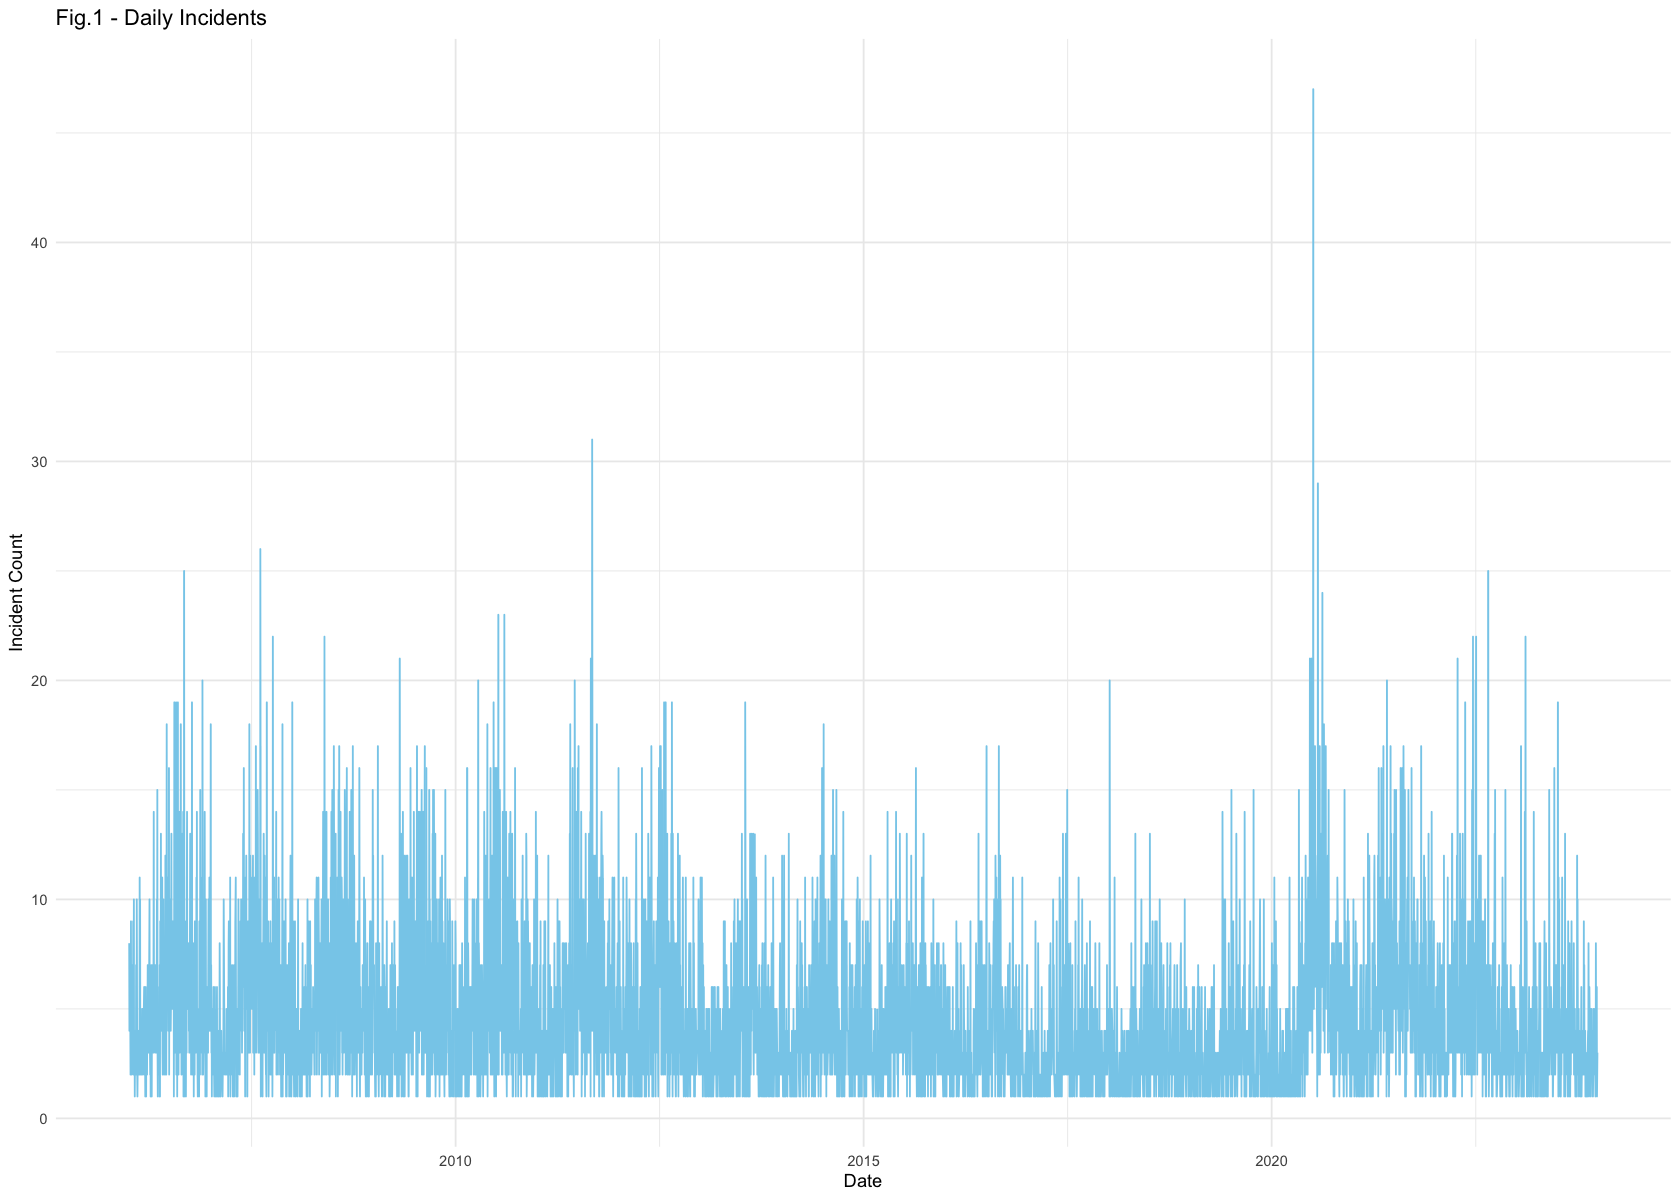

In [9]:
#| fig-align: center
theme_set(theme_minimal())

# plot daily incidents
ggplot(time_series_df, aes(x = simple_date, y = total_by_day)) +
  geom_line(color = "skyblue") +
  labs(
    title = "Fig.1 - Daily Incidents",
    x = "Date",
    y = "Incident Count"
  )

---


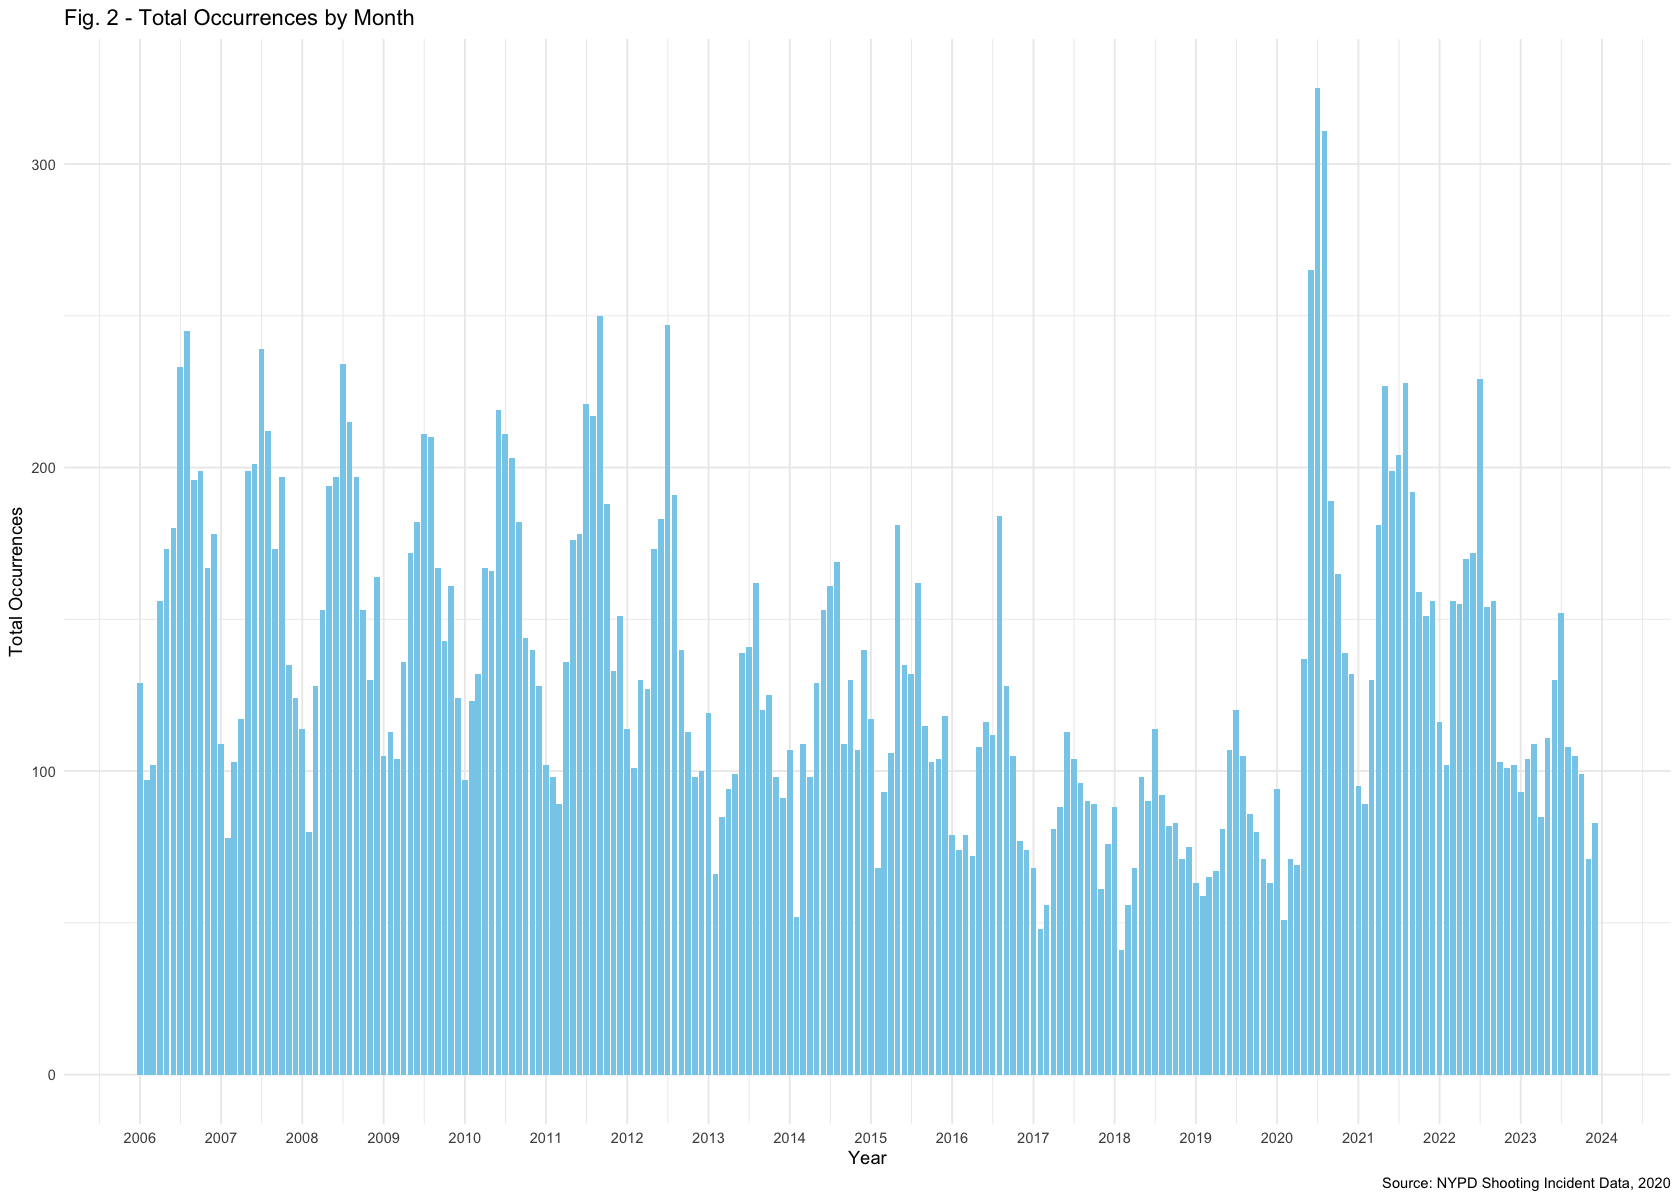

In [10]:
#| fig-align: center

# plot monthly incidents over time
ggplot(time_series_df, aes(x = month_year, y = total_by_day)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  labs(
       title = "Fig. 2 - Total Occurrences by Month",
       x = "Year", 
       y = "Total Occurrences",
       caption = "Source: NYPD Shooting Incident Data, 2020") +
  scale_x_date(date_labels = "%Y", date_breaks = "1 year")


---

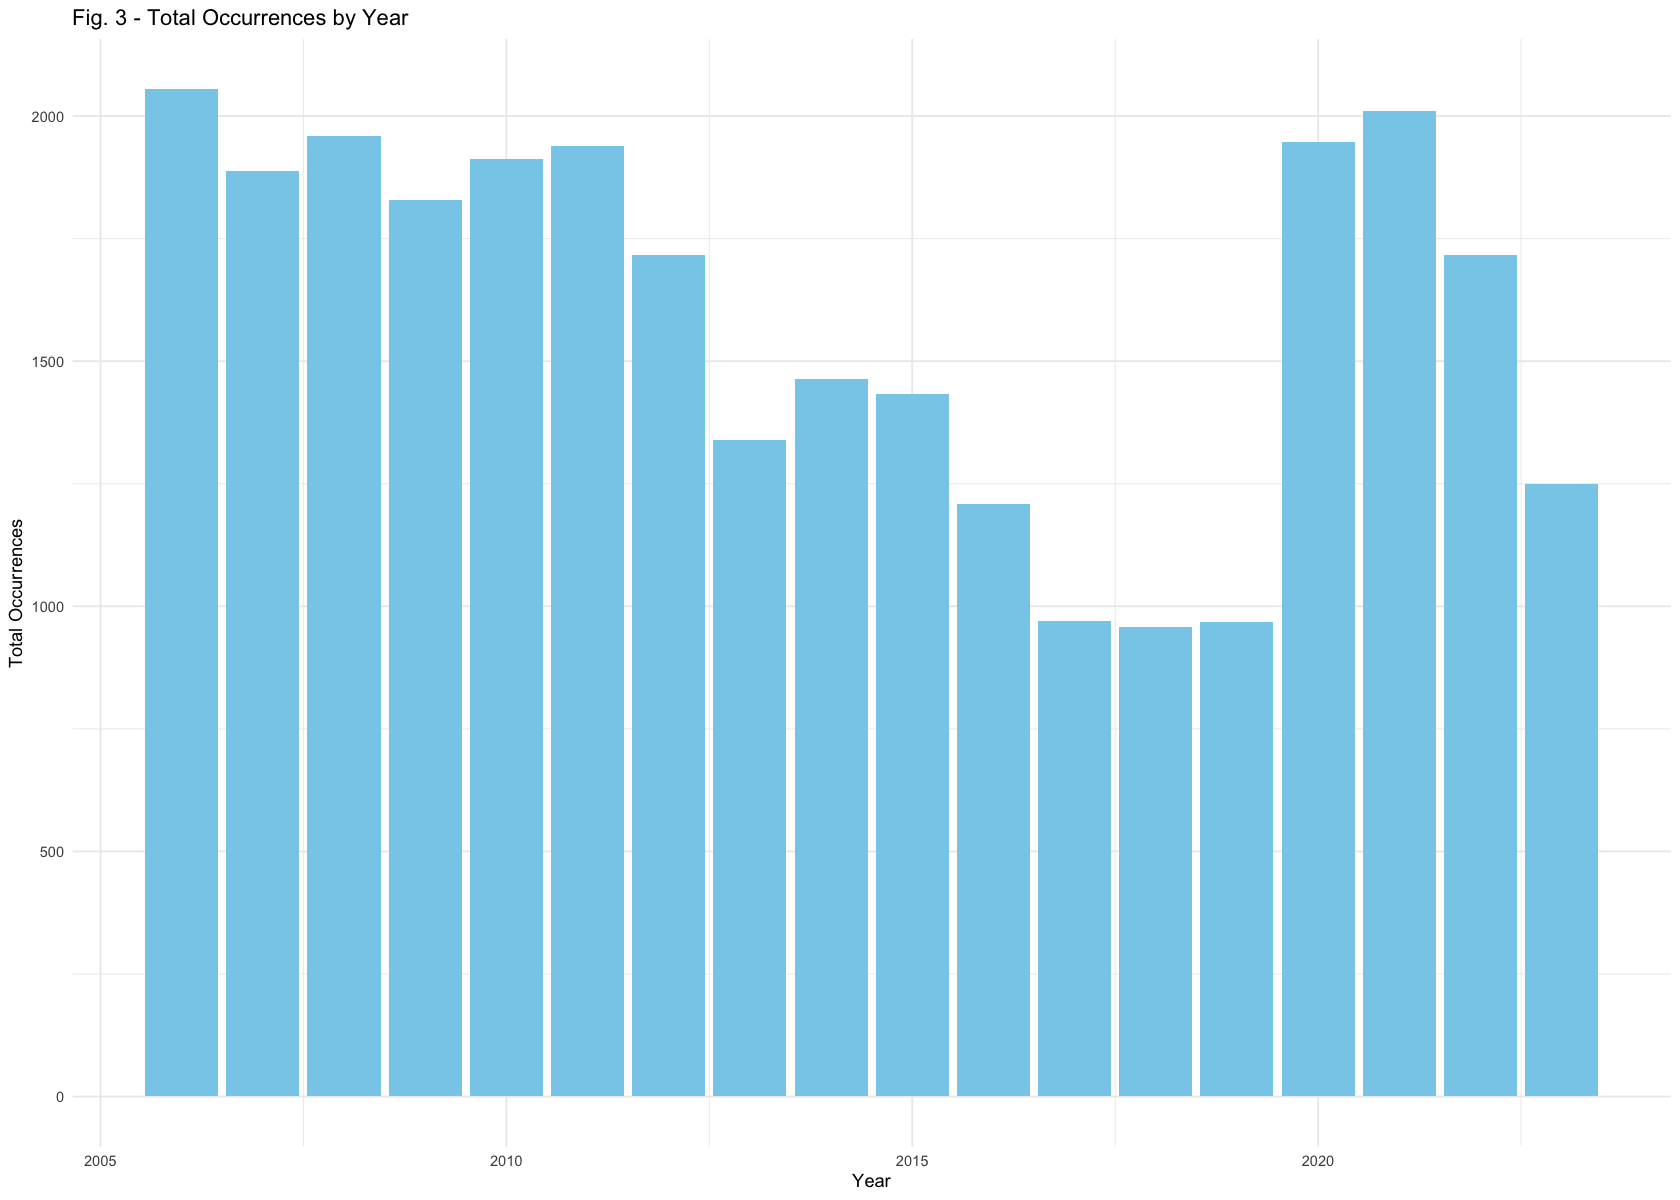

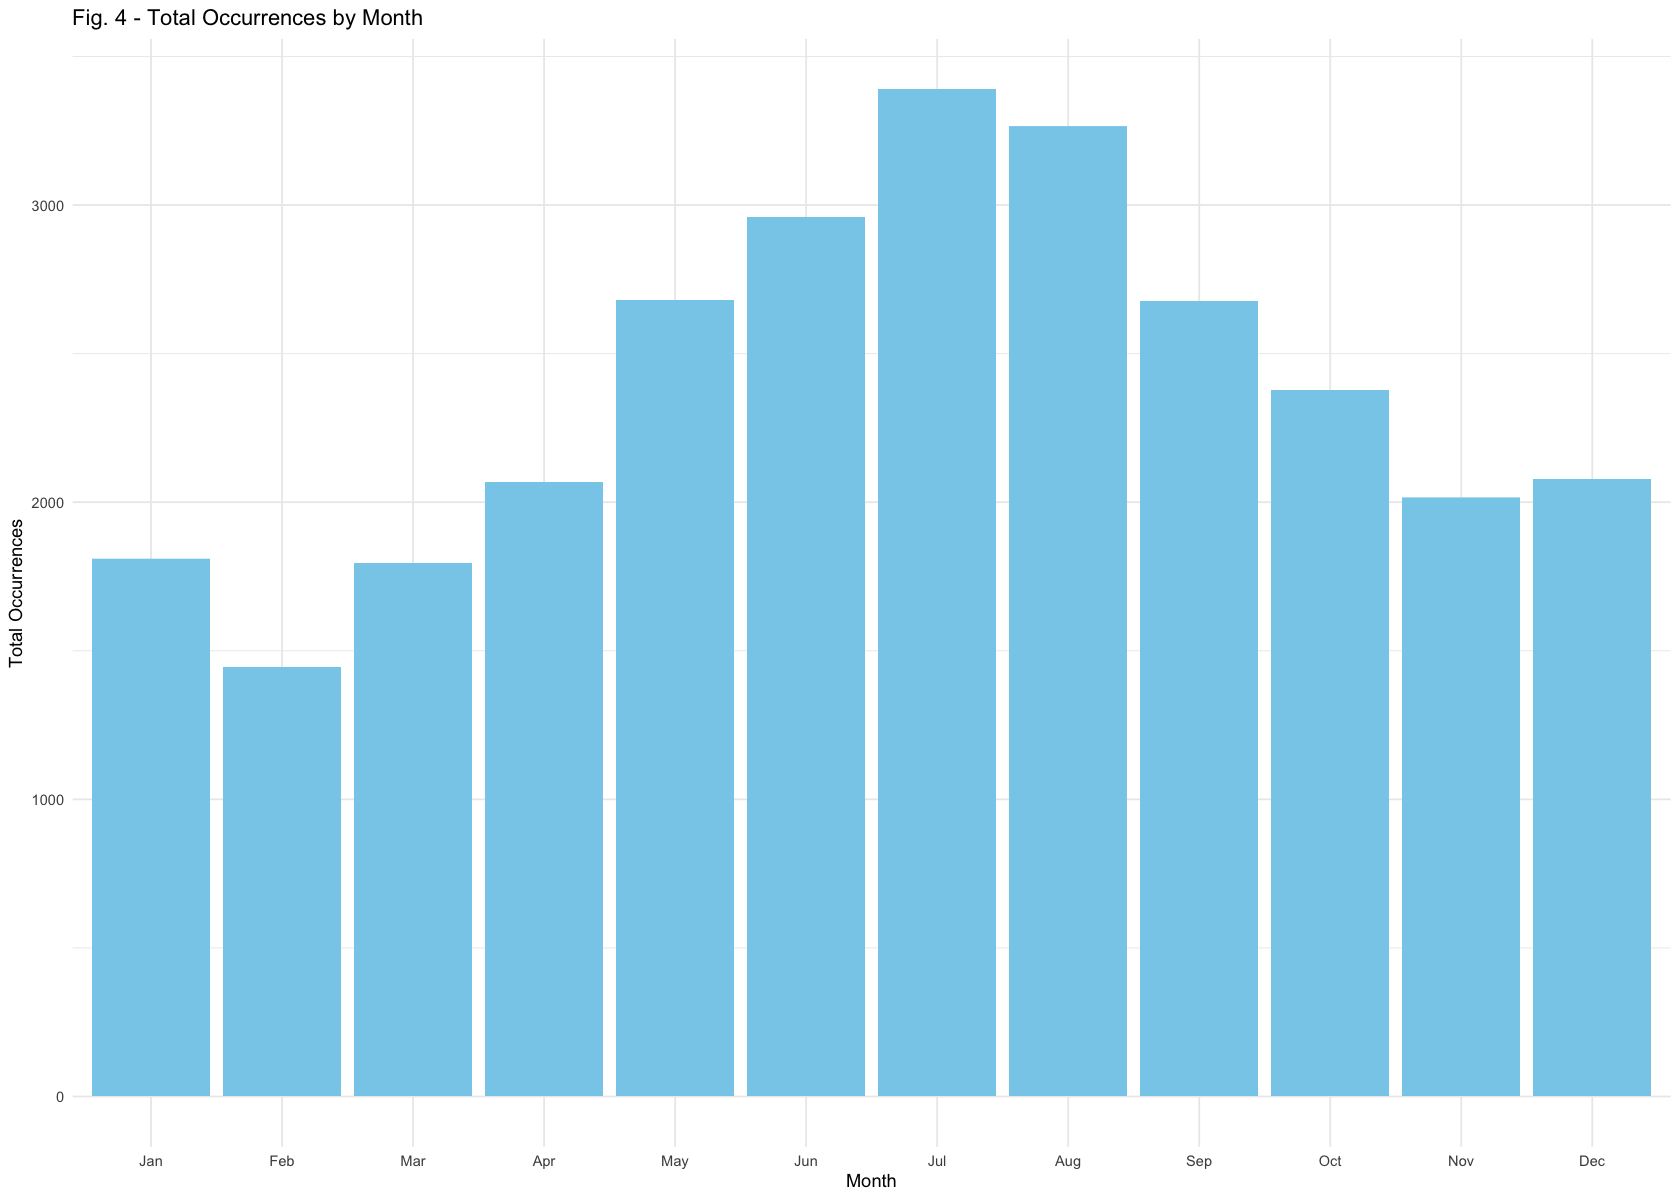

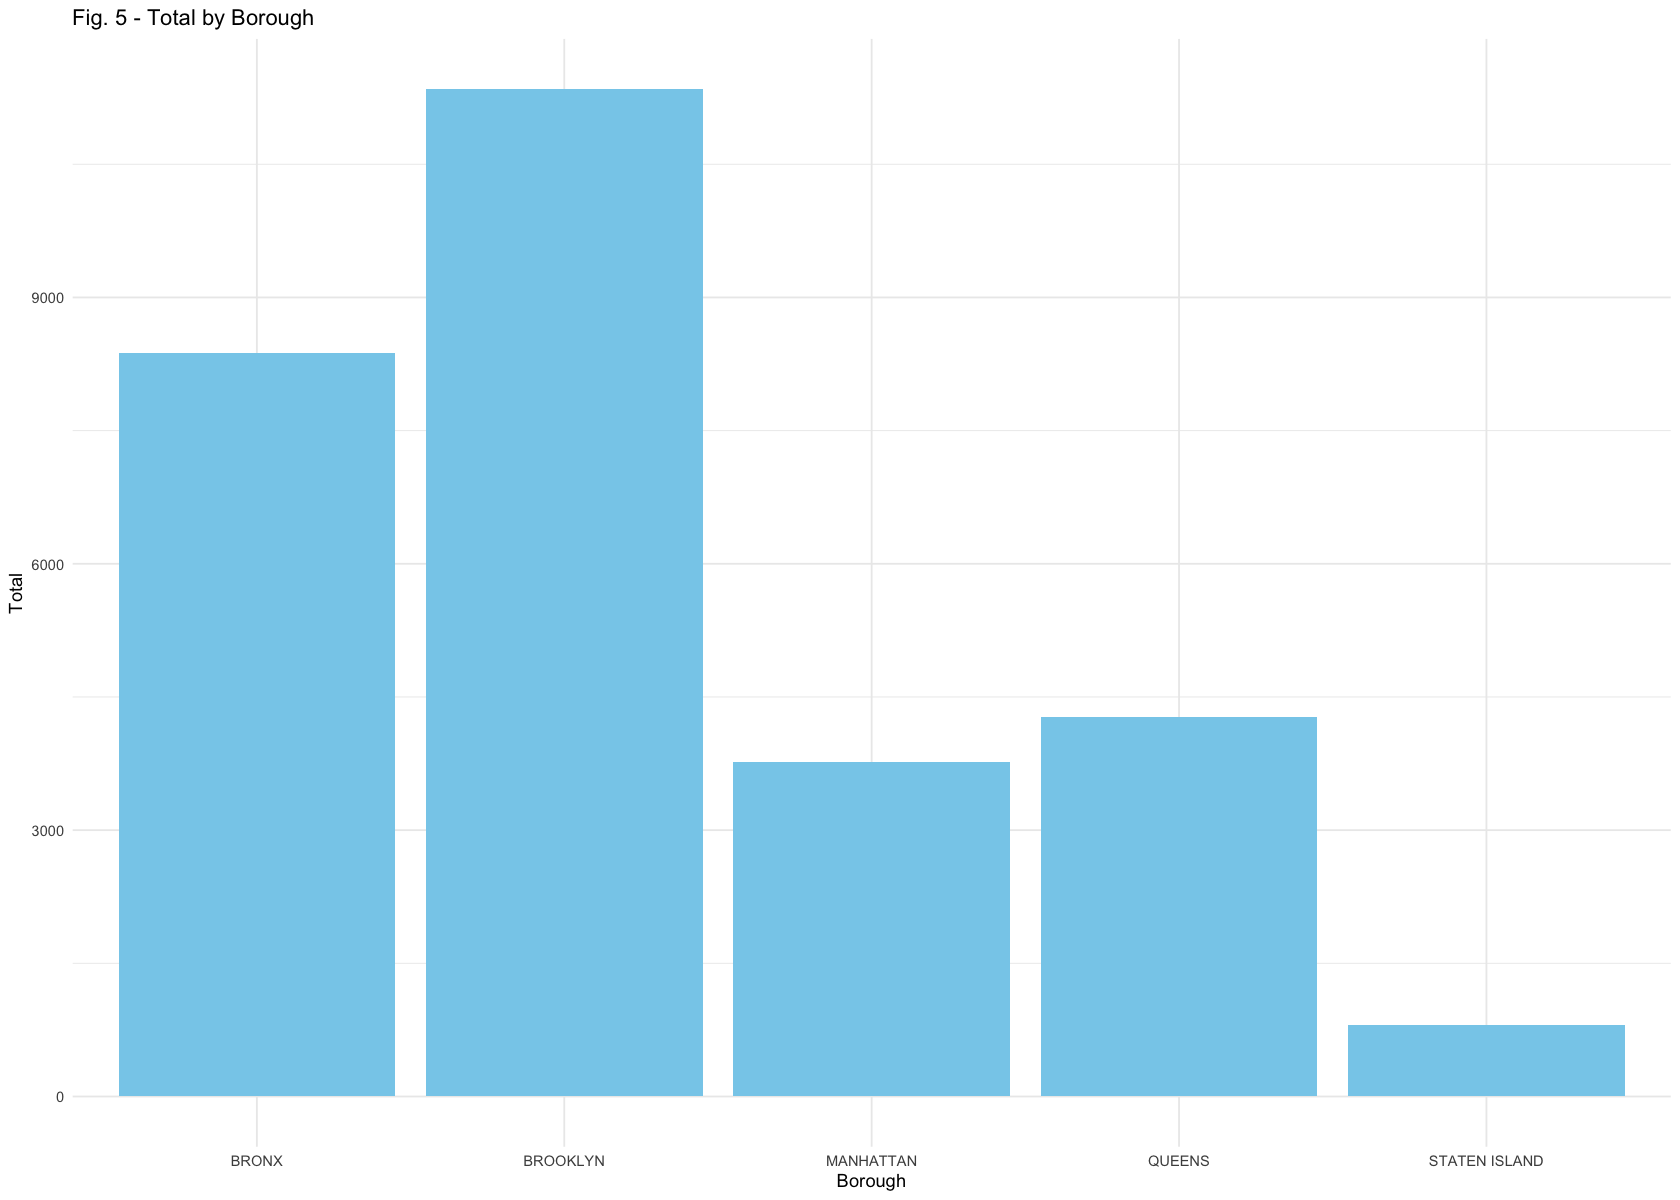

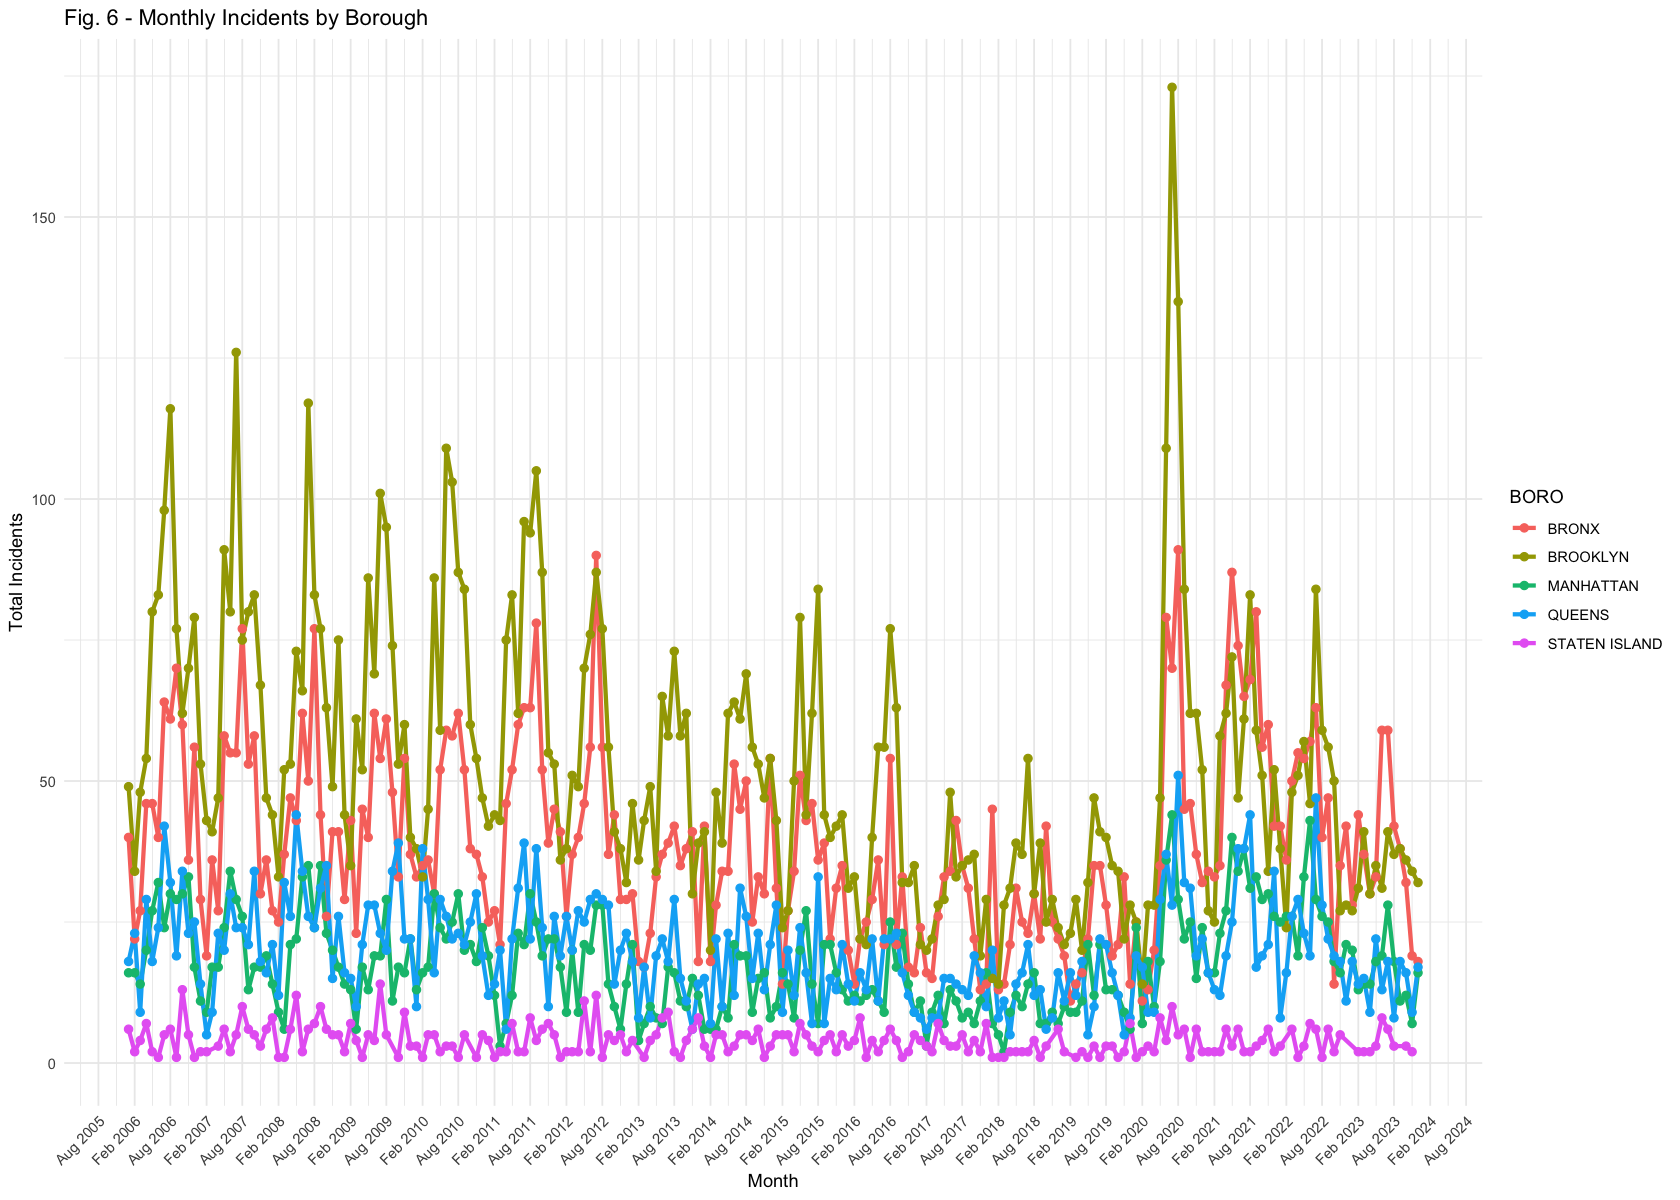

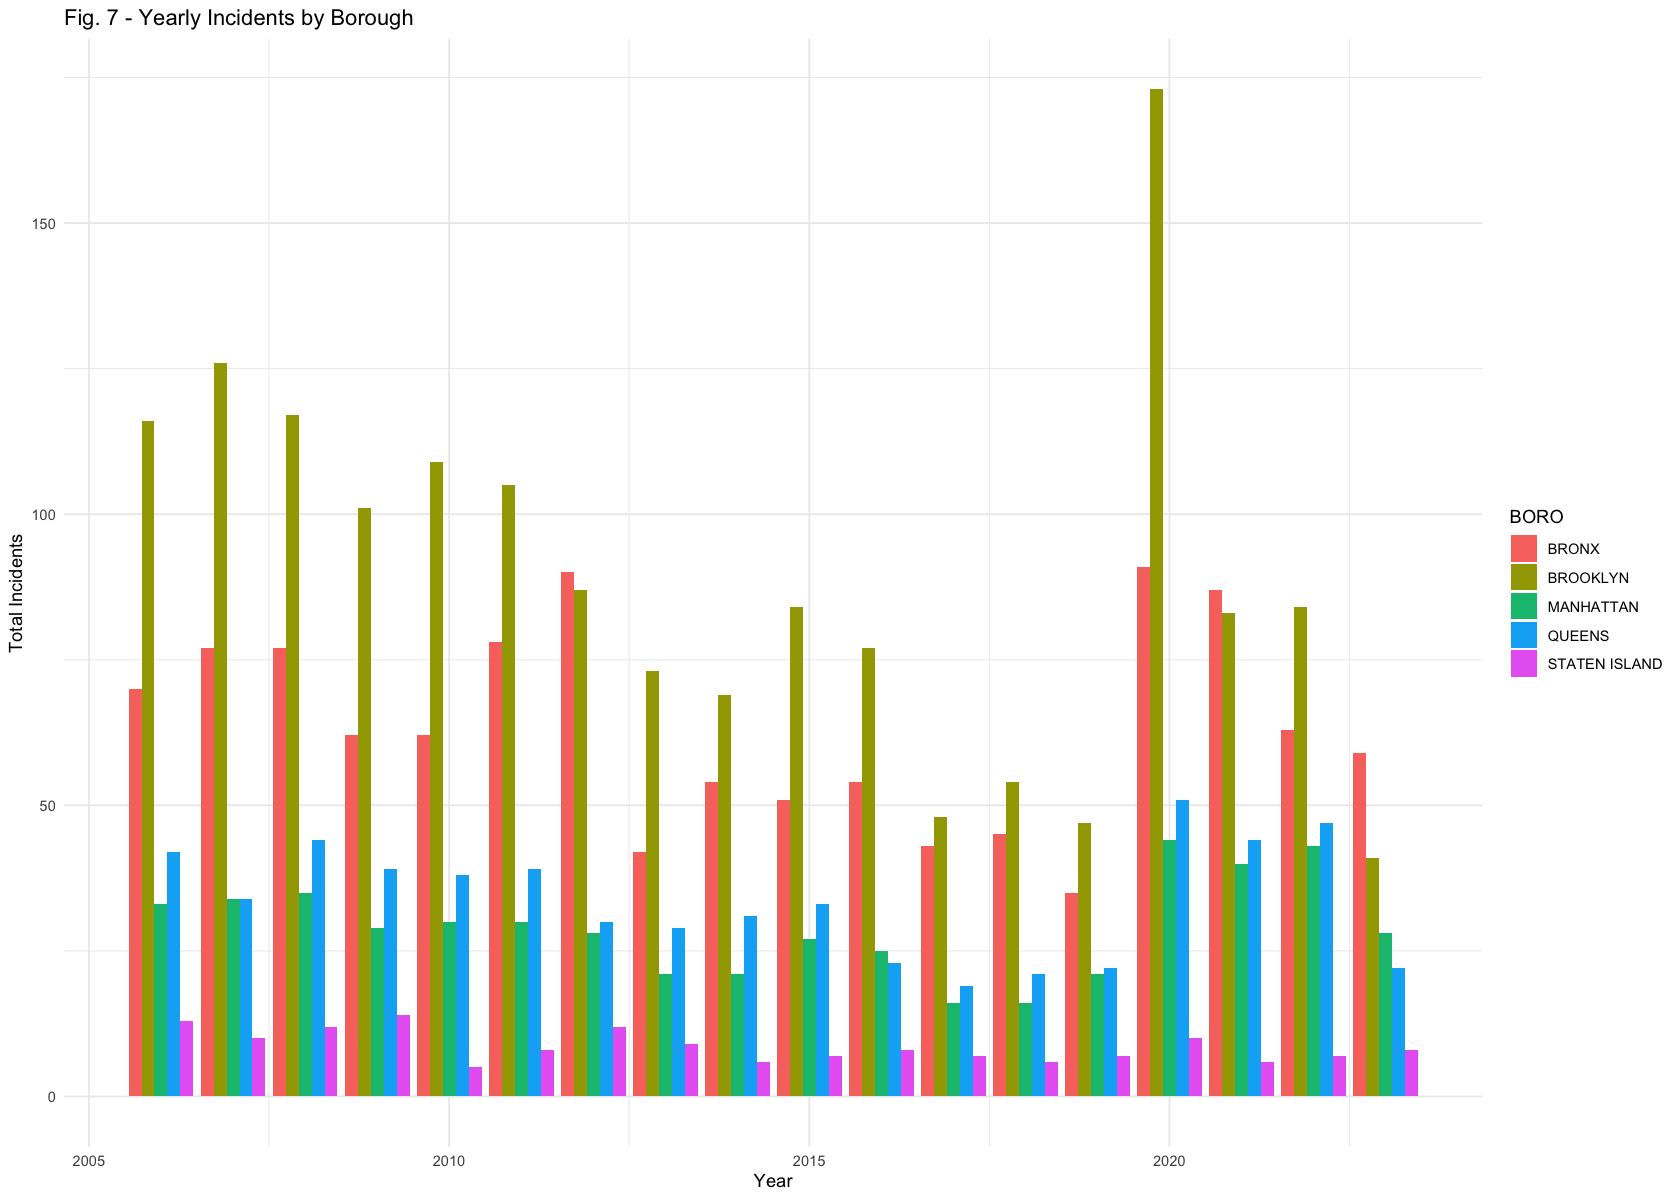

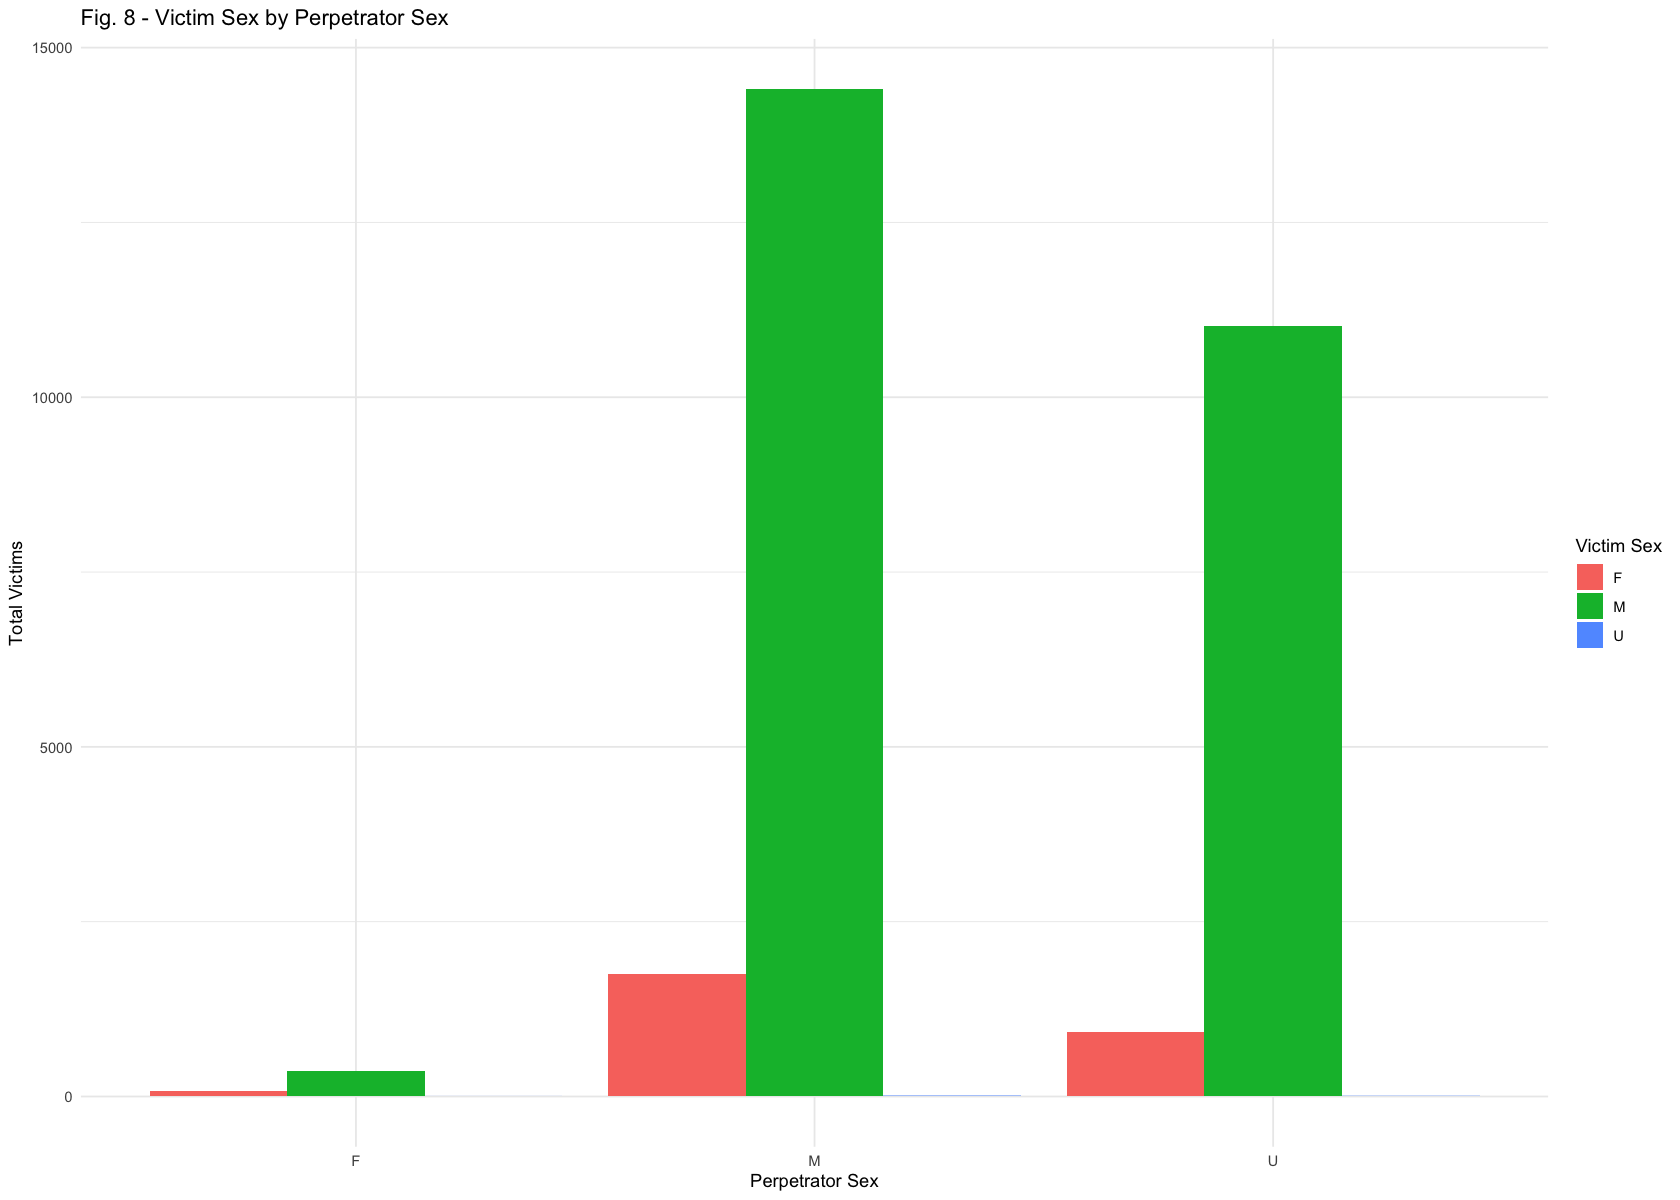

In [11]:
#| fig-align: center
# plot yearly incidents
ggplot(time_series_df, aes(
  x = year(simple_date), 
  y = total_by_day)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  labs(
       title = "Fig. 3 - Total Occurrences by Year",
       x = "Year",
       y = "Total Occurrences")


# Plot occurrences by month (across all years)
ggplot(time_series_df, aes(
  x = month(simple_date, label = TRUE),
  y = total_by_day
  )) +
  geom_bar(
    stat = "identity", 
    fill = "skyblue"
  ) +
  labs(
    title = "Fig. 4 - Total Occurrences by Month",
    x = "Month",
    y = "Total Occurrences"
  )


# Plot total by borough
ggplot(total_by_borough, aes(
  x = BORO,
  y = total_incidents
)) +
  geom_bar(
    stat = "identity",
    fill = "skyblue"
  ) +
  labs(
    title = "Fig. 5 - Total by Borough",
    x = "Borough",
    y = "Total"
  )

# Borough totals monthly
ggplot(monthly_totals_by_borough, aes(
  x = month,
  y = monthly_incidents,
  color = BORO)
  ) +
  # I wanted to try a line instead of a bar
  geom_line(linewidth = 1.2) +
  geom_point(size = 2) +
  labs(
    title = "Fig. 6 - Monthly Incidents by Borough", 
    x = "Month",
    y = "Total Incidents"
  ) +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 month") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Plot incidents by year for each borough with side-by-side bars
ggplot(monthly_totals_by_borough, aes(
  x = year(month), 
  y = monthly_incidents, 
  fill = BORO)
  ) +
  # Use dodge for side-by-side bars
  geom_bar(stat = "identity", position = "dodge") +
  labs(
    title = "Fig. 7 - Yearly Incidents by Borough",
    x = "Year",
    y = "Total Incidents")

# plot for total victims of each sex by perpetrator sex
ggplot(totals_by_sex, aes(
  x = PERP_SEX, 
  y = Total_Victims, 
  fill = VIC_SEX)
  ) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
    title = "Fig. 8 - Victim Sex by Perpetrator Sex",
    x = "Perpetrator Sex",
    y = "Total Victims",
    fill = "Victim Sex"
  ) +
  theme_minimal()


* Fig 1 -  Daily incidents - hard to see many trends since the data is so noisy, but it does look like it's generally periodic and there is a big spike around the first covid summer.
* Fig 2 -  Total occurences by month over time - clearer seasonality and a little easier to see the pre- and post-covid trends
* Fig 3 -  Total occurences by year - now we can see trends. Decreasing incidents starting in the early 20-teens and flattening out, before a big covid spike and almost back down to pre-covid levels.
* Fig 4 -  Total occurences by month - pretty strong visual trend towards higher incidents in the hottest months, which is a well studied phenomenon.
* Fig 5 -  Total by borough - generaly interesting, but would be more useful with the context of per capita and per area data for the boroughs.
* Fig 6/7 -  Boroughs over time (final 2 plots) - interesting to see that not all boroughs follow the same trends over time, and that the first covid spike was driven heavily by increased in Brooklyn.
* Fig 8 - Totals of victim sex group by perpetrator sex - there are fewer total female victims than I would have expected.

We could keep going with similar visuals (breakdown by race, gender, age group, etc. or relationships between group like victime age relative to perpetrator age) but I'll stop there. I'm going to focus on victim sex for the analysis and modeling component. I want to see how predictive of a victime being female some of the other attributes (perpetrator race and sex, victime race). I'll start with a simple model of victim sex as predicted by perpetrator sex. To start will have to exclude the "unknowns" from victim sex and clean up some of the other factors.


---

## Modeling

In [12]:
# Convert all categorical variables to factors
clean_incident_df$VIC_SEX <- factor(clean_incident_df$VIC_SEX)
clean_incident_df$BORO <- factor(clean_incident_df$BORO)
clean_incident_df$VIC_RACE <- factor(clean_incident_df$VIC_RACE)
clean_incident_df$PERP_RACE <- factor(clean_incident_df$PERP_RACE)
clean_incident_df$PERP_SEX <- factor(clean_incident_df$PERP_SEX)

# Apply droplevels to all factor columns (to remove unused levels)
clean_incident_df <- clean_incident_df %>%
  mutate_if(is.factor, droplevels)

# Set "M" as the victim reference so that we model the odds of being "Female"
# Set the reference race for victims and perps as "white"
clean_incident_df$VIC_SEX <- relevel(clean_incident_df$VIC_SEX, ref = "M")
clean_incident_df$VIC_RACE <- relevel(clean_incident_df$VIC_RACE, ref = "WHITE")
clean_incident_df$PERP_RACE <- relevel(clean_incident_df$PERP_RACE, ref = "WHITE")

# Check the levels of the factor to confirm they are correct
levels(clean_incident_df$VIC_SEX)
levels(clean_incident_df$PERP_SEX)
levels(clean_incident_df$PERP_RACE)

[1] "M" "F" "U"

[1] "F" "M" "U"

[1] "WHITE"             "(null)"            "AM_INDIAN/ALASKAN"
[4] "ASIAN_PAC_ISLAND"  "BLACK"             "BLACK HISPANIC"   
[7] "UNKNOWN"           "WHITE HISPANIC"

In [13]:
# create a simple generalize linear model to predict odds of female victim
# based on perp sex
simple_model_vic_sex <- glm(VIC_SEX ~ PERP_SEX,
  family=binomial,
  data=clean_incident_df,
  na.action = na.exclude)

summary(simple_model_vic_sex)


Call:
glm(formula = VIC_SEX ~ PERP_SEX, family = binomial, data = clean_incident_df, 
    na.action = na.exclude)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.5459     0.1247 -12.396  < 2e-16 ***
PERP_SEXM    -0.5553     0.1272  -4.364 1.28e-05 ***
PERP_SEXU    -0.9240     0.1293  -7.147 8.88e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 18197  on 28561  degrees of freedom
Residual deviance: 18093  on 28559  degrees of freedom
AIC: 18099

Number of Fisher Scoring iterations: 5


It looks like each perpetrator sex option has a statistically significant effect on the change in log-odds of the victim being female, so I'll pull out each of them and convert them to odds.

In [14]:
print("Log-odds are")
print(coef(simple_model_vic_sex)[c("PERP_SEXM","PERP_SEXU")])

#convert log-odds to odds and print
print("The odds relative to the female victim/female perpetrator baseline are")
print((exp(coef(simple_model_vic_sex)[c("PERP_SEXM","PERP_SEXU")])))

# Print odds for when the perpetrator is female
paste(
  "The odds of a victim being female when the perpetrator is female are",
  round(exp(coef(simple_model_vic_sex)["(Intercept)"]), 2)
)

# Print odds for when the perpetrator is male
paste0(
  "The odds of a victim being female when the perpetrator is male are ",
  round(exp(coef(simple_model_vic_sex)["PERP_SEXM"]), 2) * 100,
  "% of baseline"
)

# Print odds for when the perpetrator is unknown
paste0(
  "The odds of a victim being female when the perpetrator is unknown are ",
  round(exp(coef(simple_model_vic_sex)["PERP_SEXU"]), 2) * 100,
  "% of baseline"
)

[1] "Log-odds are"
 PERP_SEXM  PERP_SEXU 
-0.5552708 -0.9240283 
[1] "The odds relative to the female victim/female perpetrator baseline are"
PERP_SEXM PERP_SEXU 
0.5739169 0.3969169 


[1] "The odds of a victim being female when the perpetrator is female are 0.21"

[1] "The odds of a victim being female when the perpetrator is male are 57% of baseline"

[1] "The odds of a victim being female when the perpetrator is unknown are 40% of baseline"

In [15]:
# make a better df for monthly modeling
monthly_totals <- time_series_df %>%
  group_by(month_year) %>%
  summarise(total_by_month = sum(total_by_day))

# Check the aggregated data
tail(monthly_totals)

month_year,total_by_month
<date>,<int>
2023-07-01,152
2023-08-01,108
2023-09-01,105
2023-10-01,99
2023-11-01,71
2023-12-01,83


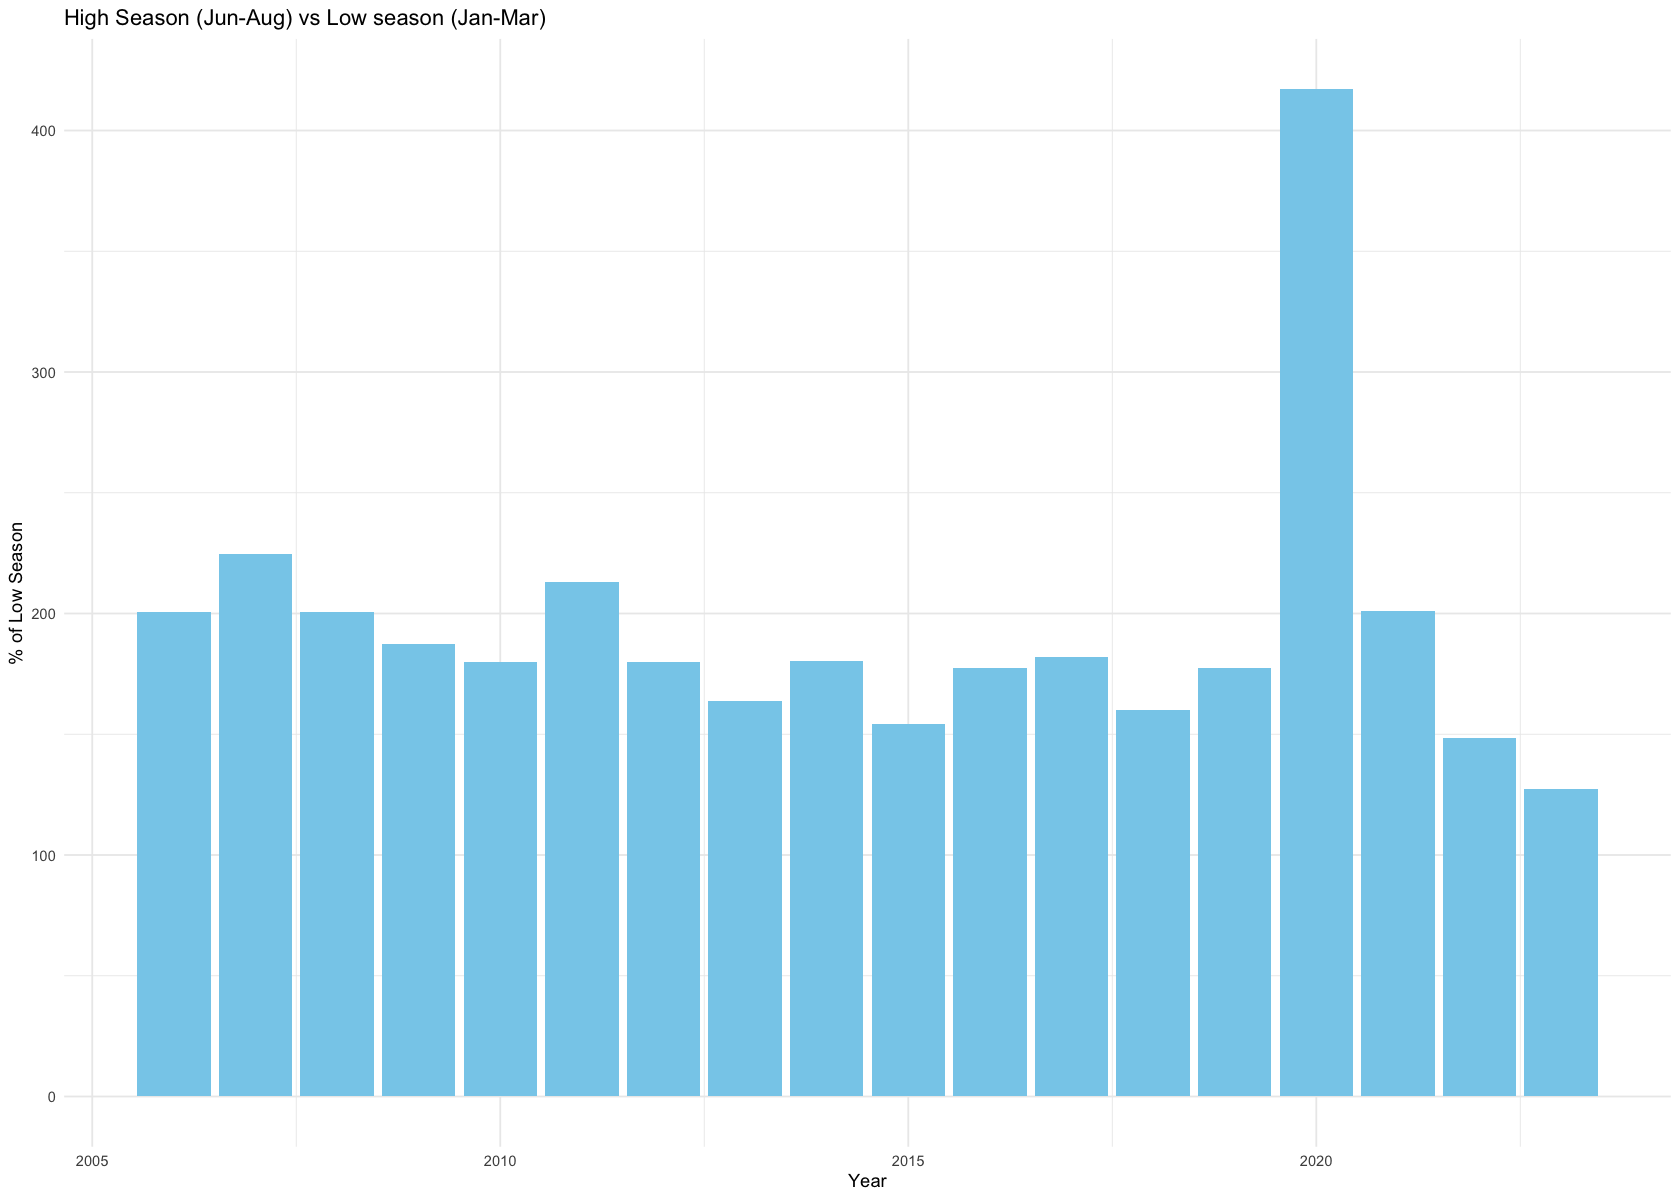

In [16]:
# make a simple ratio model based on high and low seasons
# Aggregate by year and calculate sum for January-March and 
seasonal_totals <- df_aggregated %>%
  mutate(season = case_when(
    month %in% c(1, 2, 3) ~ "low_season",
    month %in% c(6, 7, 8) ~ "high_season",
    TRUE ~ NA_character_
  )) %>%
  filter(!is.na(season)) %>%  # Filter to keep only rows with season
  group_by(year, season) %>%
  summarise(total = sum(total_by_month, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(names_from = season, values_from = total) %>%
  mutate(ratio = (high_season / low_season) * 100)

# plot the simple ratio results
ggplot(seasonal_totals, aes(
  x = year,
  y = ratio
)) + 
  geom_bar(
    stat = "identity",
    fill = "skyblue"
  ) + 
labs(
  title = "High Season (Jun-Aug) vs Low season (Jan-Mar)",
  x = "Year",
  y = "% of Low Season"
)

In [17]:
# make time series friendly
start_year <- as.numeric(format(min(monthly_totals$month_year), "%Y"))
start_month <- as.numeric(format(min(monthly_totals$month_year), "%m"))

# Convert to a time series object (monthly frequency)
monthly_incident_ts <- ts(monthly_totals$total_by_month, start = c(start_year, start_month), frequency = 12)

# Check the time series
print(monthly_incident_ts)

     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
2006 129  97 102 156 173 180 233 245 196 199 167 178
2007 109  78 103 117 199 201 239 212 173 197 135 124
2008 114  80 128 153 194 197 234 215 197 153 130 164
2009 105 113 104 136 172 182 211 210 167 143 161 124
2010  97 123 132 167 166 219 211 203 182 144 140 128
2011 102  98  89 136 176 178 221 217 250 188 133 151
2012 114 101 130 127 173 183 247 191 140 113  98 100
2013 119  66  85  94  99 139 141 162 120 125  98  91
2014 107  52 109  98 129 153 161 169 109 130 107 140
2015 117  68  93 106 181 135 132 162 115 103 104 118
2016  79  74  79  72 108 116 112 184 128 105  77  74
2017  68  48  56  81  88 113 104  96  90  89  61  76
2018  88  41  56  68  98  90 114  92  82  83  71  75
2019  63  59  65  67  81 107 120 105  86  80  71  63
2020  94  51  71  69 137 265 325 311 189 165 139 132
2021  95  89 130 181 227 199 204 228 192 159 151 156
2022 116 102 156 155 170 172 229 154 156 103 101 102
2023  93 104 109  85 111 130 152 108 105  99  

Series: monthly_incident_ts 
ARIMA(1,0,0)(1,1,0)[12] with drift 

Coefficients:
         ar1     sar1    drift
      0.6957  -0.3703  -0.3007
s.e.  0.0507   0.0662   0.4204

sigma^2 = 906.9:  log likelihood = -983.79
AIC=1975.58   AICc=1975.78   BIC=1988.85

Training set error measures:
                      ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.01241811 29.05056 21.49203 -2.150574 17.37663 0.7560569
                    ACF1
Training set -0.07634969

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"Removed 156 rows containing missing values or values outside the scale range
(`geom_line()`)."


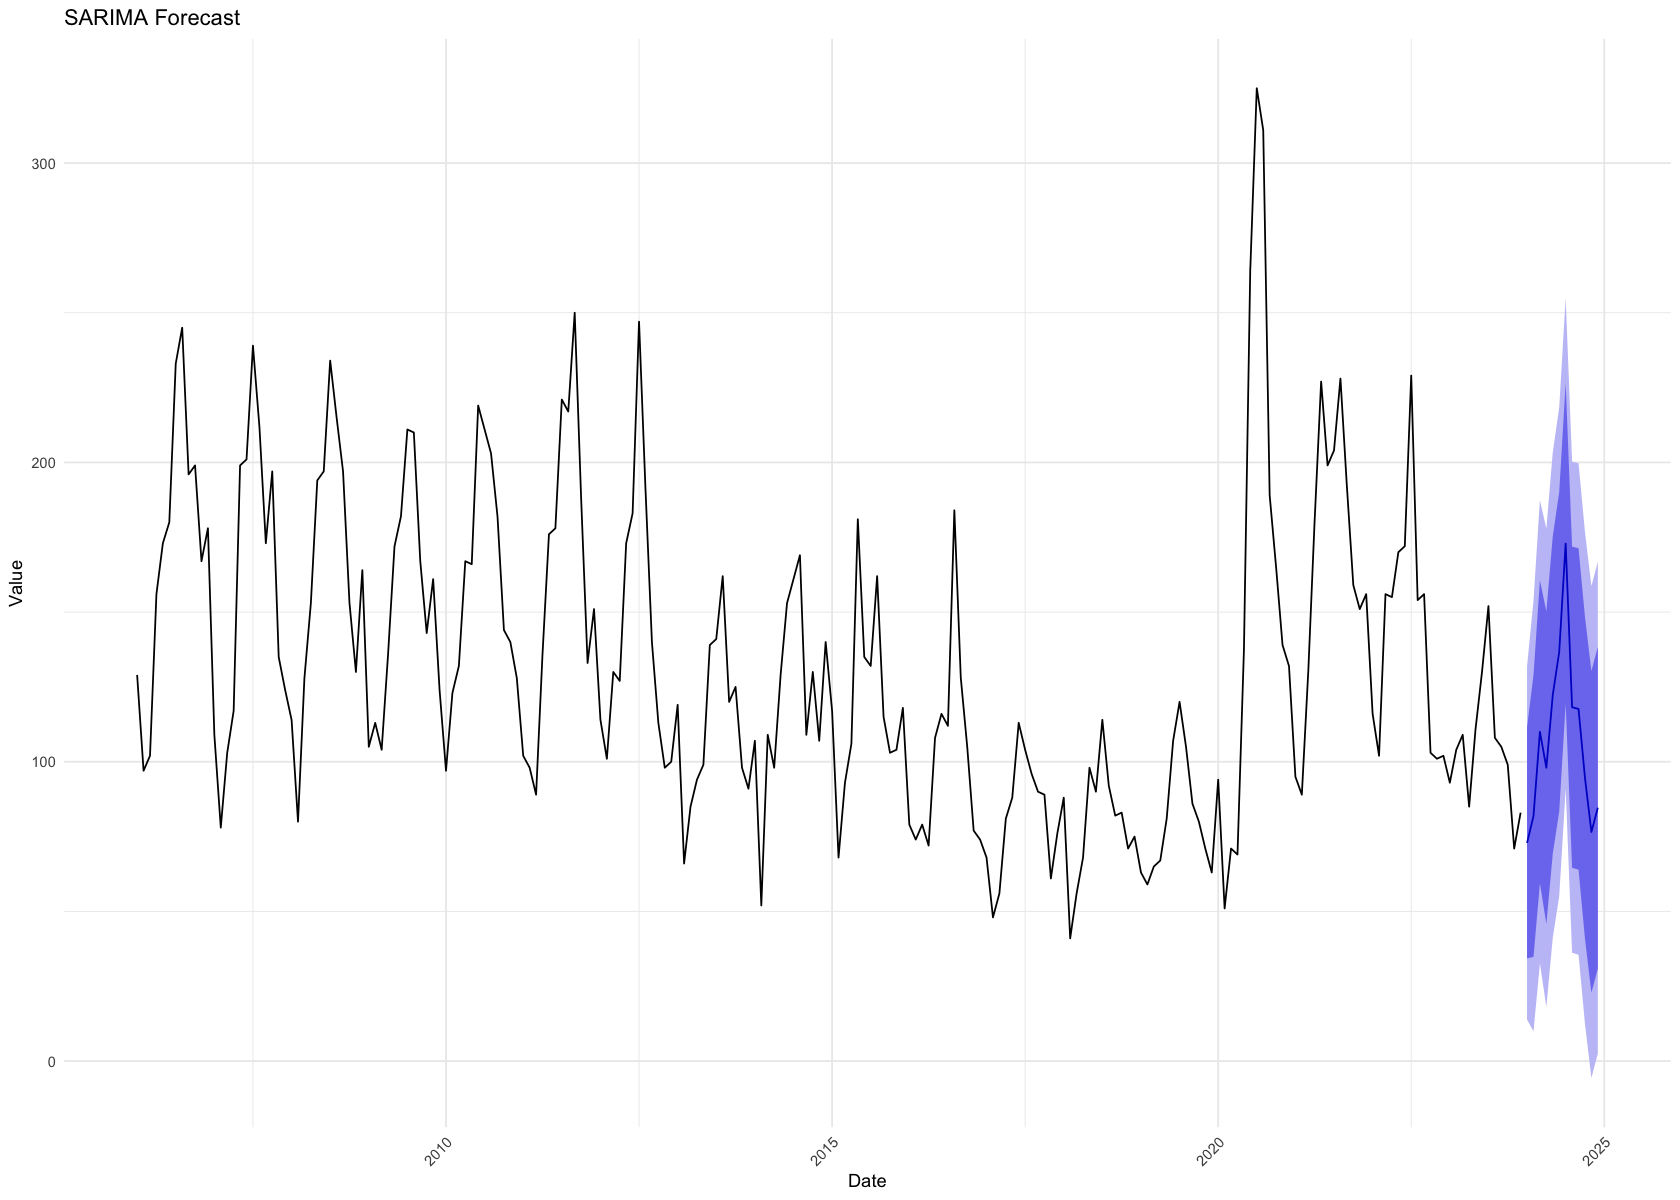

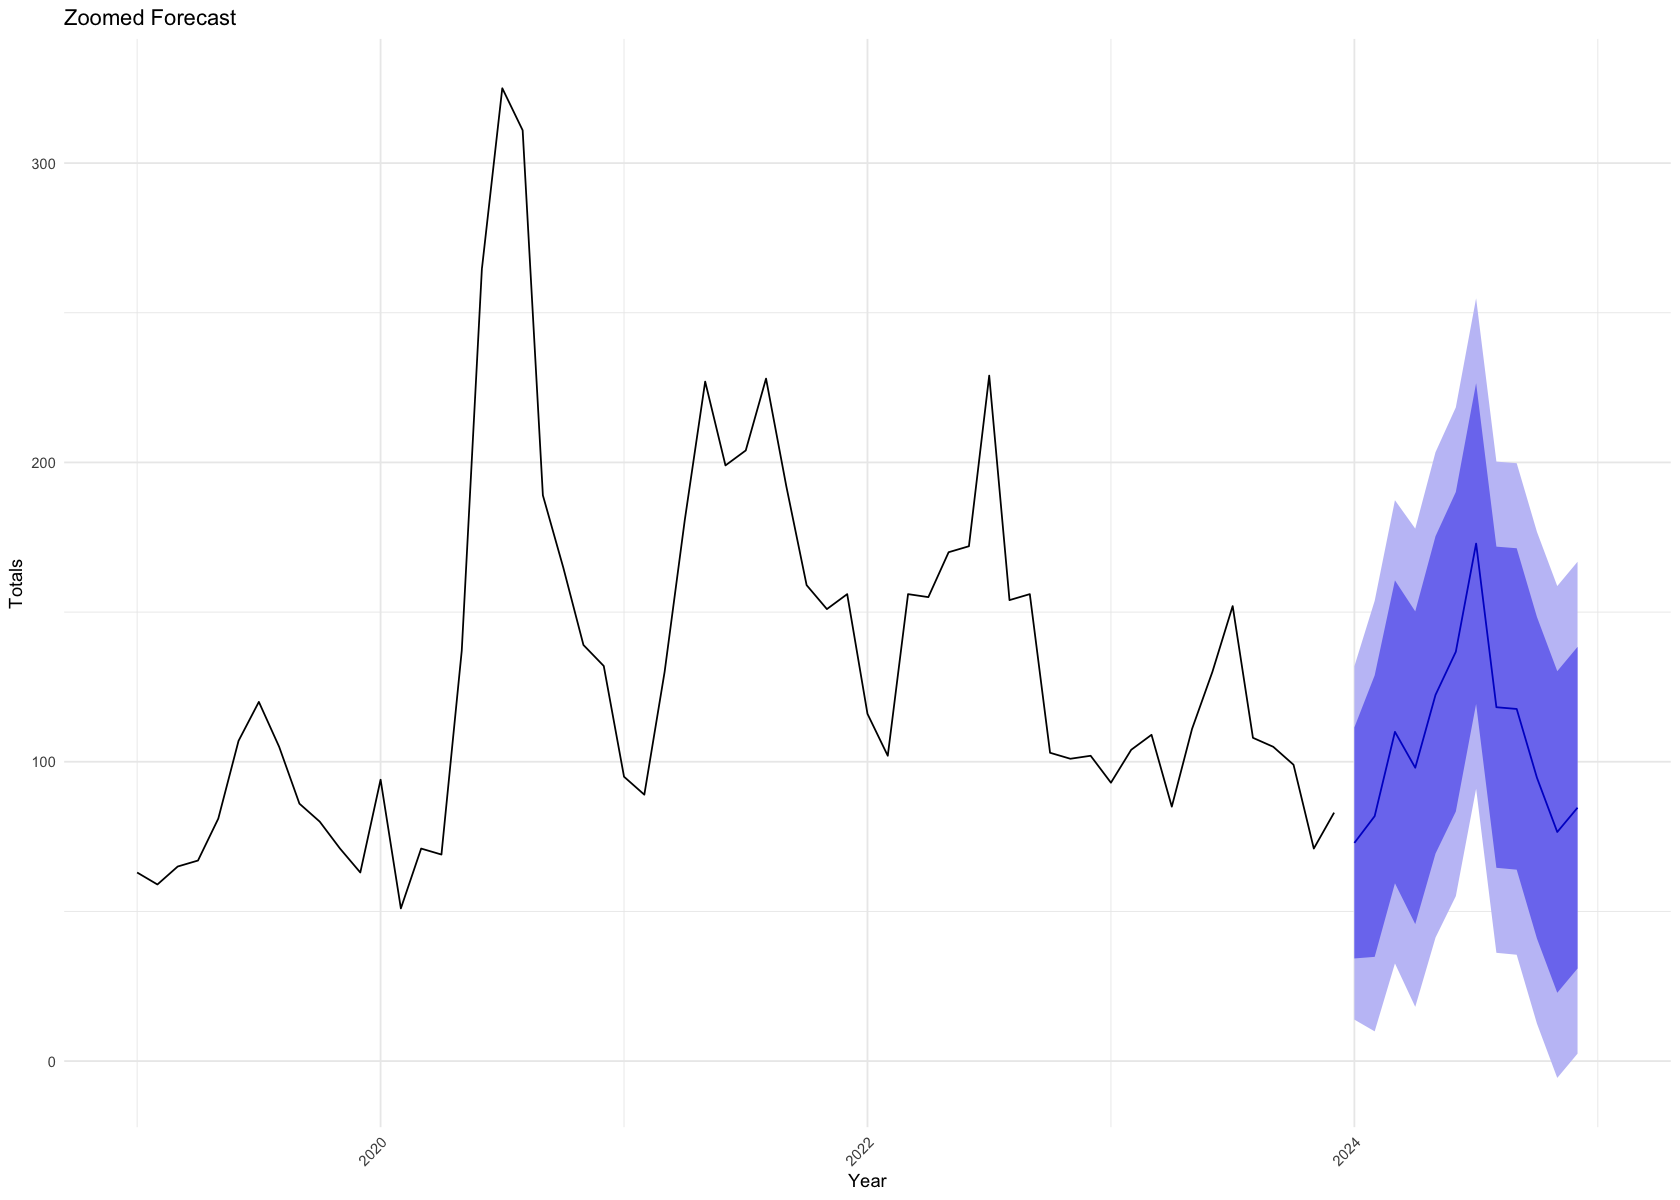

In [18]:
sarima_forecast <- auto.arima(monthly_incident_ts, seasonal = TRUE)

# Summary of the SARIMA model
summary(sarima_forecast)

# Forecasting the next 12 months
forecast_values <- forecast::forecast(sarima_forecast, h = 12)

# Plot the forecast
autoplot(forecast_values) +
  labs(x = "Date", y = "Value", title = "SARIMA Forecast") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# create a zoomed in version
autoplot(forecast_values) +
  labs(title = "Zoomed Forecast", x = "Year", y = "Totals") +
  xlim(c(2019, 2025)) +  # Adjust x-axis to show the previous 12 months and forecast
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [19]:
# Print the confidence intervals for the next 5 months
next_12_conf_intervals <- data.frame(
  month2024 = c(1:12),  
  forecast = forecast_values$mean[1:12],
  lower_80 = forecast_values$lower[1:12, 1],  # 80% lower bound
  upper_80 = forecast_values$upper[1:12, 1],  # 80% upper bound
  lower_95 = forecast_values$lower[1:12, 2],
  upper_95 = forecast_values$upper[1:12, 2]
) %>%
  mutate(across(everything(), \(x) round(x, 0))
)

next_12_conf_intervals

month2024,forecast,lower_80,upper_80,lower_95,upper_95
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,73,34,111,14,132
2,82,35,129,10,154
3,110,59,161,33,187
4,98,46,150,18,178
5,122,69,175,41,203
6,137,83,190,55,218
7,173,119,226,91,255
8,118,65,172,36,200
9,118,64,171,36,200


That's the end of the analysis I'm comfortable with. Below I wanted to see what it would look like to do similar modeling with multiple predictor variables (perp sex, race, borough.) It looks like it worked, but it gets out of hand to interpret it pretty quickly so I just stopped and left it here as an interesting example of what else could be done.

In [20]:
model_vic_sex <- glm(VIC_SEX ~ BORO + VIC_RACE + 
  PERP_SEX + PERP_RACE, 
  family=binomial, 
  data=clean_incident_df,
  na.action = na.exclude)

print(levels(clean_incident_df$VIC_RACE))
print(levels(clean_incident_df$PERP_RACE))
print(levels(clean_incident_df$BORO))
print(summary(model_vic_sex))

[1] "WHITE"             "AM_INDIAN/ALASKAN" "ASIAN_PAC_ISLAND" 
[4] "BLACK"             "BLACK HISPANIC"    "UNKNOWN"          
[7] "WHITE HISPANIC"   
[1] "WHITE"             "(null)"            "AM_INDIAN/ALASKAN"
[4] "ASIAN_PAC_ISLAND"  "BLACK"             "BLACK HISPANIC"   
[7] "UNKNOWN"           "WHITE HISPANIC"   
[1] "BRONX"         "BROOKLYN"      "MANHATTAN"     "QUEENS"       
[5] "STATEN ISLAND"

Call:
glm(formula = VIC_SEX ~ BORO + VIC_RACE + PERP_SEX + PERP_RACE, 
    family = binomial, data = clean_incident_df, na.action = na.exclude)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.06855    0.20611  -5.184 2.17e-07 ***
BOROBROOKLYN                0.16083    0.05205   3.090 0.002003 ** 
BOROMANHATTAN               0.11455    0.06716   1.706 0.088079 .  
BOROQUEENS                  0.17563    0.06462   2.718 0.006571 ** 
BOROSTATEN ISLAND           0.22120    0.11703   1.890 0.058742 .  
VIC_RACEAM_INDIAN/AL

In [21]:
#| echo: false
#| include: false

library(broom)

tidy_model <- tidy(model_vic_sex)
print(tidy_model, n=Inf)

# A tibble: 20 x 5
   term                       estimate std.error statistic      p.value
   <chr>                         <dbl>     <dbl>     <dbl>        <dbl>
 1 (Intercept)                 -1.07      0.206    -5.18   0.000000217 
 2 BOROBROOKLYN                 0.161     0.0521    3.09   0.00200     
 3 BOROMANHATTAN                0.115     0.0672    1.71   0.0881      
 4 BOROQUEENS                   0.176     0.0646    2.72   0.00657     
 5 BOROSTATEN ISLAND            0.221     0.117     1.89   0.0587      
 6 VIC_RACEAM_INDIAN/ALASKAN   -0.607     1.06     -0.574  0.566       
 7 VIC_RACEASIAN_PAC_ISLAND    -0.719     0.200    -3.60   0.000324    
 8 VIC_RACEBLACK               -0.627     0.113    -5.57   0.0000000249
 9 VIC_RACEBLACK HISPANIC      -0.569     0.128    -4.44   0.00000904  
10 VIC_RACEUNKNOWN             -0.207     0.374    -0.552  0.581       
11 VIC_RACEWHITE HISPANIC      -0.305     0.119    -2.56   0.0105      
12 PERP_SEXM                   -0.545     0.1

In [22]:
#| echo: false
#| include: false

# Convert to a dataframe and print
tidy_model_df <- as.data.frame(tidy_model)

# Print the dataframe (all rows will be printed)
# Format specific numeric columns with decimal notation and fixed decimal places
tidy_model_df_formatted <- tidy_model_df
tidy_model_df_formatted$p.value <- format(
  tidy_model_df_formatted$p.value, scientific = FALSE, digits = 1)


# Print the entire dataframe with the formatted column(s)
(tidy_model_df_formatted)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.06854909,0.20610903,-5.18438755,0.00000022
BOROBROOKLYN,0.16083104,0.05205232,3.08979570,0.00200294
BOROMANHATTAN,0.11454658,0.06715835,1.70561950,0.08807895
BOROQUEENS,0.17562567,0.06461955,2.71784115,0.00657094
BOROSTATEN ISLAND,0.22119774,0.11702845,1.89011947,0.05874198
VIC_RACEAM_INDIAN/ALASKAN,-0.60707405,1.05696993,-0.57435319,0.56572882
VIC_RACEASIAN_PAC_ISLAND,-0.71881356,0.19993913,-3.59516191,0.00032419
VIC_RACEBLACK,-0.62711661,0.11250110,-5.57431530,0.00000002
VIC_RACEBLACK HISPANIC,-0.56913986,0.12821443,-4.43896891,0.00000904


## Potential Bias {.smaller}

There are several sources of potential bias in this report:

* **Collection bias**: Some of the categorical variable options, such as the descriptions of locations or location categories, are limited, and some actual locations may be ambiguous. The racial categorization options are also somewhat limited compared to the true diversity of racial and ethnic backgrounds. The racial categorization is likely to have been chosen by someone other than the subject, so the selected race may not be accurate or reflect how the subject (victim or perpetrator) would self-identify.

* **Analysis bias**: There are likely many interesting insights in this data regarding race (relationship between race of perpetrator and victim, racial distribution of incidents throughout the boroughs, etc.), but I deliberately avoided any in-depth analysis of those categories. I believed it would be more complicated and nuanced than my current ability and available time would allow me to do well.
---

In [23]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: aarch64-apple-darwin20
Running under: macOS Sonoma 14.6.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] C

time zone: America/Denver
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] broom_1.0.6     forecast_8.23.0 lubridate_1.9.3 forcats_1.0.0  
 [5] stringr_1.5.1   dplyr_1.1.4     purrr_1.0.2     readr_2.1.5    
 [9] tidyr_1.3.1     tibble_3.2.1    ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    stringi_1.8.4     lattice_0.22-6   
 [5] hms_1.1.3         digest_0.6.36     magrittr_2.0.3    evaluate_0.24.0  
 [9] grid_4.4.1        timechange_0.3.0  pbdZMQ_0.3-11     fastmap_1.2.0    